In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau

Data Ingestion:

In [2]:

# Data paths
csv_path = "/Users/architmurgudkar/Documents/MDSI/ILAB/SkinCapDataFolder/skincap_v240623.csv"
img_dir = "/Users/architmurgudkar/Documents/MDSI/ILAB/SkinCapDataFolder/skincap"


In [3]:
# Read CSV file
df = pd.read_csv(csv_path)

In [4]:
# List of columns to predict
columns_to_predict = [
    'Vesicle', 'Papule', 'Macule', 'Plaque', 'Abscess', 'Pustule', 'Bulla', 
    'Patch', 'Nodule', 'Ulcer', 'Crust', 'Erosion', 'Excoriation', 'Atrophy', 
    'Exudate', 'Purpura/Petechiae', 'Fissure', 'Induration', 'Xerosis', 
    'Telangiectasia', 'Scale', 'Scar', 'Friable', 'Sclerosis', 'Pedunculated', 
    'Exophytic/Fungating', 'Warty/Papillomatous', 'Dome-shaped', 'Flat topped', 
    'Brown(Hyperpigmentation)', 'Translucent', 'White(Hypopigmentation)', 
    'Purple', 'Yellow', 'Black', 'Erythema', 'Comedo', 'Lichenification', 
    'Blue', 'Umbilicated', 'Poikiloderma', 'Salmon', 'Wheal', 'Acuminate', 
    'Burrow', 'Gray', 'Pigmented', 'Cyst'
]

In [5]:
class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, img_dir, columns_to_keep, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.columns_to_keep = columns_to_keep
        self.transform = transform
        self.to_tensor = transforms.ToTensor()
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['skincap_file_path']
        img_path = os.path.join(self.img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            else:
                image = self.to_tensor(image)
        except Exception as e:
            print(f"Error loading image: {img_path}")
            print(f"Error details: {str(e)}")
            image = torch.zeros((3, 224, 224))
        
        labels = torch.FloatTensor(self.dataframe.iloc[idx][self.columns_to_keep].values.astype(np.float32))
        return image, labels

In [6]:
# Improved data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


Label Counts in the Full Dataset:
Vesicle: 41
Papule: 1454
Macule: 34
Plaque: 1963
Abscess: 4
Pustule: 94
Bulla: 59
Patch: 147
Nodule: 212
Ulcer: 150
Crust: 496
Erosion: 186
Excoriation: 40
Atrophy: 66
Exudate: 138
Purpura/Petechiae: 10
Fissure: 30
Induration: 27
Xerosis: 33
Telangiectasia: 94
Scale: 714
Scar: 118
Friable: 149
Sclerosis: 23
Pedunculated: 30
Exophytic/Fungating: 45
Warty/Papillomatous: 62
Dome-shaped: 194
Flat topped: 16
Brown(Hyperpigmentation): 1032
Translucent: 19
White(Hypopigmentation): 256
Purple: 78
Yellow: 243
Black: 104
Erythema: 2190
Comedo: 26
Lichenification: 22
Blue: 5
Umbilicated: 45
Poikiloderma: 5
Salmon: 12
Wheal: 18
Acuminate: 8
Burrow: 5
Gray: 4
Pigmented: 5
Cyst: 5


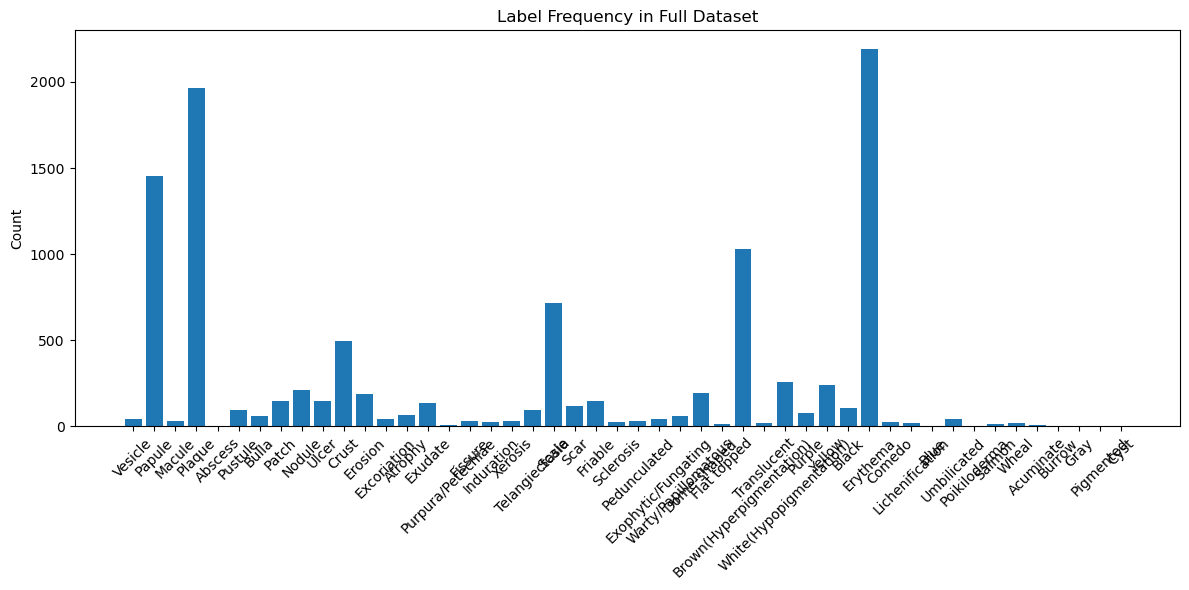

In [7]:
# Count the number of times each output variable appears in the full dataset
label_counts_full = df[columns_to_predict].sum(axis=0)
label_counts_dict_full = {col: count for col, count in zip(columns_to_predict, label_counts_full)}

print("\nLabel Counts in the Full Dataset:")
for col, count in label_counts_dict_full.items():
    print(f"{col}: {count}")

# Plot label frequency for the full dataset using matplotlib
plt.figure(figsize=(12, 6))
plt.bar(columns_to_predict, label_counts_full)
plt.title('Label Frequency in Full Dataset')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Data Processing:

In [9]:
def filter_low_frequency_labels(df, columns_to_predict, threshold=40):
    label_counts = df[columns_to_predict].sum(axis=0)
    columns_to_keep = label_counts[label_counts >= threshold].index.tolist()
    columns_to_keep_with_path = ['skincap_file_path'] + columns_to_keep
    filtered_df = df[columns_to_keep_with_path]
    print(f"Kept columns: {columns_to_keep_with_path}")
    return filtered_df, columns_to_keep

# Apply the threshold on df
filtered_df, columns_to_keep = filter_low_frequency_labels(df, columns_to_predict, threshold=40)

Kept columns: ['skincap_file_path', 'Vesicle', 'Papule', 'Plaque', 'Pustule', 'Bulla', 'Patch', 'Nodule', 'Ulcer', 'Crust', 'Erosion', 'Excoriation', 'Atrophy', 'Exudate', 'Telangiectasia', 'Scale', 'Scar', 'Friable', 'Exophytic/Fungating', 'Warty/Papillomatous', 'Dome-shaped', 'Brown(Hyperpigmentation)', 'White(Hypopigmentation)', 'Purple', 'Yellow', 'Black', 'Erythema', 'Umbilicated']


In [11]:
def preprocess_filtered_dataframe(df, columns_to_keep):
    df.loc[:, columns_to_keep] = df[columns_to_keep].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
    return df

# Apply preprocessing to the filtered DataFrame
filtered_df = preprocess_filtered_dataframe(filtered_df, columns_to_keep)

# Split the data into training and validation sets
train_df, val_df = train_test_split(filtered_df, test_size=0.2, random_state=42)

EfficientNet Model:

In [12]:
# Updated model architecture
class SkinLesionModel(nn.Module):
    def __init__(self, num_classes):
        super(SkinLesionModel, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, num_classes)
        )
    
    def forward(self, x):
        return self.efficientnet(x)  # Remove sigmoid here

In [13]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')
        self.val_loss_min = val_loss


In [14]:
# Mixup augmentation
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [15]:
# Initialize model, loss function, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SkinLesionModel(num_classes=len(columns_to_keep)).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Create datasets and data loaders
train_dataset = SkinLesionDataset(train_df, img_dir, columns_to_keep, transform=data_transforms)
val_dataset = SkinLesionDataset(val_df, img_dir, columns_to_keep, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

/Users/architmurgudkar/pytorch-test/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/architmurgudkar/pytorch-test/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/architmurgudkar/pytorch-test/env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model Training:

In [16]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Mixup augmentation
        images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.2)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(train_loader)

In [17]:
# Updated validation function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            preds = torch.sigmoid(outputs) > 0.3  # Lower threshold and apply sigmoid
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = running_loss / len(val_loader)
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels.flatten(), all_preds.flatten())
    f1 = f1_score(all_labels, all_preds, average='micro', zero_division=1)
    precision = precision_score(all_labels, all_preds, average='micro', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='micro', zero_division=1)
    
    return val_loss, f1, precision, recall, accuracy, all_labels, all_preds

In [18]:
# Training loop
num_epochs = 30
best_f1 = 0.0
early_stopping = EarlyStopping(patience=5, verbose=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, f1, precision, recall, accuracy, all_labels, all_preds = validate_model(model, val_loader, criterion, device)
    
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    
    scheduler.step(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved best model")
    
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    print()
    print("_"*30)

print("Training complete!")

Epoch 1/30
Train Loss: 0.2359, Val Loss: 0.2206
F1 Score: 0.5256, Precision: 0.4726, Recall: 0.5921, Accuracy: 0.8976
Saved best model
Validation loss decreased (inf --> 0.220605). Saving model ...

______________________________
Epoch 2/30
Train Loss: 0.2088, Val Loss: 0.2068
F1 Score: 0.5469, Precision: 0.5414, Recall: 0.5524, Accuracy: 0.9123
Saved best model
Validation loss decreased (0.220605 --> 0.206796). Saving model ...

______________________________
Epoch 3/30
Train Loss: 0.2010, Val Loss: 0.1978
F1 Score: 0.5686, Precision: 0.5567, Recall: 0.5810, Accuracy: 0.9156
Saved best model
Validation loss decreased (0.206796 --> 0.197836). Saving model ...

______________________________
Epoch 4/30
Train Loss: 0.1947, Val Loss: 0.1972
F1 Score: 0.5858, Precision: 0.5814, Recall: 0.5901, Accuracy: 0.9200
Saved best model
Validation loss decreased (0.197836 --> 0.197173). Saving model ...

______________________________
Epoch 5/30
Train Loss: 0.1910, Val Loss: 0.1942
F1 Score: 0.5817,

In [19]:
# Final evaluation
model.load_state_dict(torch.load('best_model.pth'))
val_loss, f1, precision, recall, accuracy, all_labels, all_preds = validate_model(model, val_loader, criterion, device)
print("Final Model Performance:")
print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")


/var/folders/nv/j4_t175j49n9hdxl0mfy3jbh0000gn/T/ipykernel_32586/3099293308.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

Final Model Performance:
F1 Score: 0.6000, Precision: 0.5596, Recall: 0.6467, Accuracy: 0.9174


Classification Report:

In [20]:
# Print classification report
class_names = columns_to_keep
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=1))


Classification Report:
                          precision    recall  f1-score   support

                 Vesicle       0.00      0.00      1.00         9
                  Papule       0.51      0.84      0.63       287
                  Plaque       0.64      0.86      0.73       394
                 Pustule       0.50      0.12      0.19        17
                   Bulla       0.50      0.07      0.12        15
                   Patch       0.00      0.00      1.00        24
                  Nodule       0.40      0.16      0.23        49
                   Ulcer       0.40      0.38      0.39        32
                   Crust       0.41      0.64      0.50        91
                 Erosion       0.45      0.12      0.19        42
             Excoriation       1.00      0.00      0.00         6
                 Atrophy       1.00      0.00      0.00        15
                 Exudate       0.75      0.33      0.46        27
          Telangiectasia       0.00      0.00      

In [25]:
def tta_predict(model, image, num_augmentations=5):
    model.eval()
    predictions = []
    for _ in range(num_augmentations):
        aug_image = data_transforms(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(aug_image)
        predictions.append(output)
    return torch.sigmoid(torch.stack(predictions).mean(0))

# Example of using TTA for a single image prediction
sample_image_path = '/Users/architmurgudkar/Documents/MDSI/ILAB/SkinCapDataFolder/skincap/3889.png'
sample_image = Image.open(sample_image_path).convert('RGB')
tta_prediction = tta_predict(model, sample_image)
final_prediction = tta_prediction > 0.3  # Using the same threshold as in validation

# Get the actual labels for this image
image_filename = sample_image_path.split('/')[-1]  # Extract filename from path
actual_labels = df[df['skincap_file_path'] == image_filename][columns_to_keep].iloc[0]

# Print the predictions and actual labels
print("Comparison of TTA Predictions and Actual Labels:")
print(f"{'Class':<30} {'Predicted':<10} {'Actual':<10} {'Probability':<10}")
print("-" * 60)
for i, col in enumerate(columns_to_keep):
    predicted = final_prediction[0][i].item()
    actual = actual_labels[col]
    probability = tta_prediction[0][i].item()
    print(f"{col:<30} {predicted:<10} {actual:<10} {probability:.4f}")

# Calculate and print accuracy for this sample
correct_predictions = sum([1 for i, col in enumerate(columns_to_keep) if final_prediction[0][i].item() == actual_labels[col]])
accuracy = correct_predictions / len(columns_to_keep)
print(f"\nAccuracy for this sample: {accuracy:.2f}")

Comparison of TTA Predictions and Actual Labels:
Class                          Predicted  Actual     Probability
------------------------------------------------------------
Vesicle                        0          0          0.0016
Papule                         1          0          0.4001
Plaque                         1          1          0.3902
Pustule                        0          0          0.0063
Bulla                          0          0          0.0132
Patch                          0          0          0.0181
Nodule                         0          0          0.0905
Ulcer                          0          0          0.0104
Crust                          0          0          0.0691
Erosion                        0          0          0.0260
Excoriation                    0          0          0.0042
Atrophy                        0          0          0.0136
Exudate                        0          0          0.0046
Telangiectasia                 0          0  

Classification Matrix:

IndexError: index 27 is out of bounds for axis 1 with size 27

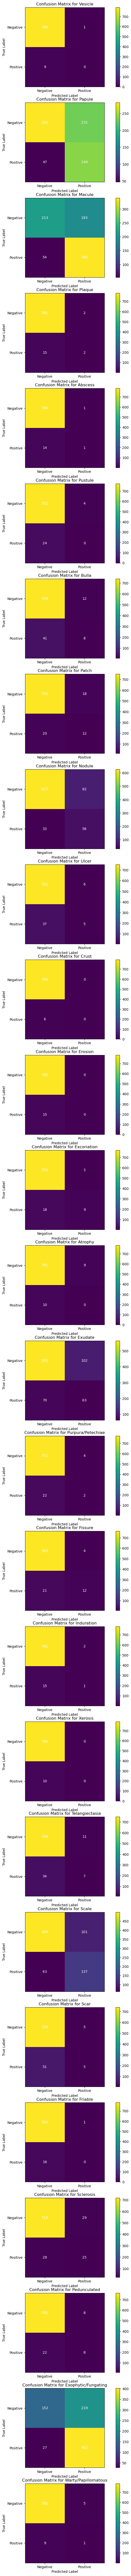

In [26]:
from sklearn.metrics import confusion_matrix
# Confusion matrix generation for each label and visualization
plt.figure(figsize=(12, len(columns_to_predict) * 5))

for i, col in enumerate(columns_to_predict):
    # Compute confusion matrix for each label
    cm = confusion_matrix(all_labels[:, i], all_preds[:, i])
    
    # Plot the confusion matrix
    plt.subplot(len(columns_to_predict), 1, i+1)
    plt.imshow(cm, interpolation='none')
    plt.title(f"Confusion Matrix for {col}")
    plt.colorbar()
    
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])
    
    # Annotate confusion matrix with values
    for j in range(cm.shape[0]):
        for k in range(cm.shape[1]):
            plt.text(k, j, f"{cm[j, k]}", ha="center", va="center", color="white")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()